# This Notebook is for analyzing and processing the output of scrap in GCP

Context: Given the significant number of jobs on the LinkedIn site, it isn't easy to do an accurate search.
The search needs to be more precise, even with the site's filters.
With this, we captured this data to develop more precise ways of searching for the perfect match job.  


Solution: Scrap all job data on the LinkedIn site automatically. After collecting the data, was developed a strategy for creating new columns with unstructured data in the description that will help with the search job process.  

Techniques: A personalized NER(Name entity recognition) strategy was used to find automatically and structure entities from the unstructured description job. Also, NLP strategies using the spacy library and nltk. Also, topic modeling and visual dependencies from the text.  

# Libs

In [1]:
import pandas as pd
import json
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import nltk

In [3]:
import pandas_gbq
from google.oauth2 import service_account

from google.cloud import bigquery
%load_ext google.cloud.bigquery

from google.oauth2 import service_account

# Create BigQuery table for save data scraped

This code is for creating a table in the Big Query database to save all the data that will be scrapped.

In [3]:
credentials = service_account.Credentials.from_service_account_file( 'teste-315517-6ebeb5337f4a.json', )    
pandas_gbq.context.credentials = credentials

In [4]:
project_id = 'teste-315517'
bigquery_client = bigquery.Client(credentials= credentials,project=project_id)

In [6]:
import datetime

In [8]:
now_datetime = datetime.datetime.now()
print(now_datetime)

2023-04-16 17:25:58.476962


In [11]:
schema_scrp=[
    bigquery.SchemaField("title", "STRING"),
    bigquery.SchemaField("location", "STRING"),
    bigquery.SchemaField("company_name", "STRING"),
    bigquery.SchemaField("position_name", "STRING"),
    bigquery.SchemaField("experience_required", "STRING"),
    bigquery.SchemaField("contract_type", "STRING"),
    bigquery.SchemaField("function_name", "STRING"),
    bigquery.SchemaField("company_sector", "STRING"),
    bigquery.SchemaField("description", "STRING"),
    bigquery.SchemaField("link", "STRING"),
    bigquery.SchemaField("now_datetime", "STRING")
]

In [12]:
#criando tabela no bq cpf
table_id = 'teste-315517.teste.raw_from_linkedin'

table = bigquery.Table(table_id, schema=schema_scrp)
table = bigquery_client.create_table(table)  # Make an API request.
print(
    "Created table {}.{}.{}".format(table.project, table.dataset_id, table.table_id)
)

Created table teste-315517.teste.raw_from_linkedin


This table is to save all entities that will be extracted

In [105]:
credentials = service_account.Credentials.from_service_account_file( 'teste-315517-6ebeb5337f4a.json', )    
pandas_gbq.context.credentials = credentials
project_id = 'teste-315517'
bigquery_client = bigquery.Client(credentials= credentials,project=project_id)

In [106]:
schema_scrp=[
    bigquery.SchemaField("now_datetime", "STRING"),
    bigquery.SchemaField("link", "STRING"),
    bigquery.SchemaField("skills", "STRING"),
    bigquery.SchemaField("contract", "STRING"),
    bigquery.SchemaField("education", "STRING"),
    bigquery.SchemaField("constraints", "STRING"),
    bigquery.SchemaField("experience", "STRING"),
    bigquery.SchemaField("money", "STRING"),
]

In [107]:
#criando tabela no bq cpf
table_id = 'teste-315517.teste.ner_extracted_from_linkedin'

table = bigquery.Table(table_id, schema=schema_scrp)
table = bigquery_client.create_table(table)  # Make an API request.
print(
    "Created table {}.{}.{}".format(table.project, table.dataset_id, table.table_id)
)

Created table teste-315517.teste.ner_extracted_from_linkedin


# Functions

In [4]:
def clean_column_strings(df):
    """Clean each column of a dirty dataframe

    Args:
        df (dataframe): dataframe to be clean

    Returns:
        dataframe: cleaned dataframe
    """
    
    df['location'] = df['location'].apply(lambda x: x.replace("\n", "").strip() if type(x) == str else x)
    df['company_name'] = df['company_name'].apply(lambda x: x.replace("\n", "").strip() if type(x) == str else x)
    df['experience_required'] = df['experience_required'].apply(lambda x: x.replace("\n", "").strip() if type(x) == str else x)
    df['contract_type'] = df['contract_type'].apply(lambda x: x.replace("\n", "").strip() if type(x) == str else x)
    df['function_name'] = df['function_name'].apply(lambda x: x.replace("\n", "").strip() if type(x) == str else x)
    df['company_sector'] = df['company_sector'].apply(lambda x: x.replace("\n", "").strip() if type(x) == str else x)
    clean = re.compile('<.*?>')
    df['description'] = df['description'].apply(lambda x: re.sub(clean, '', x).replace('\n','').strip())
    df['description'] = df['description'].apply(lambda x: word_split(x))
    
    return df

In [5]:
def word_split(text):
    """Split some words that are imprecisaly toguether after scrap

    Args:
        text (string): string to process

    Returns:
        string: string processed
    """
    # replaces each uppercase letter with a space followed by the same lower case letter
    #text = re.sub(r'([a-z])([A-Z])', r'\1 \2', text)
    text = re.sub('<[^<]+?>', '', text)

    return text.strip()



In [6]:
def calculate_na_proportion(df):
    """Build a dataframe with some information about null values on the dataframe

    Args:
        df (dataframe): dataframe to calculate

    Returns:
        dataframe: dataframe with null proportions
    """

    # exploratory DF with % NA and types values
    na_proportion = pd.DataFrame({'name' : df.columns, 'type' : df.dtypes,
                            'NA #': df.isna().sum(), 'NA %' : (df.isna().sum() / df.shape[0]) * 100})
    return na_proportion

# Loading data

All data scraped are in the Big Query database and will be used for this analyze

In [17]:
credentials = service_account.Credentials.from_service_account_file(
    'teste-315517-6ebeb5337f4a.json',
)
pandas_gbq.context.credentials = credentials

sql = """
SELECT 
*
 FROM `teste-315517.teste.raw_from_linkedin`
  """

# Run a Standard SQL query with the project set explicitly
project_id = 'teste-315517'
df = pd.read_gbq(sql, project_id=project_id, dialect='standard')

In [18]:
df_raw_bigquery = df.copy()

### Clean durty data

After the scrapy phase, some columns have special characters that were removed in this step.

In [19]:
df_job = clean_column_strings(df_raw_bigquery)

In [20]:
df_job

,title,location,company_name,position_name,experience_required,contract_type,function_name,company_sector,description,link,now_datetime
0,"Associate Education Research Scientist, AD-173...","Wallops Island, VA",USAJOBS,"Associate Education Research Scientist, AD-173...",Mid-Senior level,Full-time,Other,Human Resources Services,DutiesWe encourage you to read this entire vac...,https://www.linkedin.com/jobs/view/3589288300,2023-04-29 03:15:45.101879
1,"Education Research Scientist, AD-1730-00, (TER...","Wallops Island, VA",USAJOBS,"Education Research Scientist, AD-1730-00, (TER...",Mid-Senior level,Full-time,Other,Human Resources Services,DutiesWe encourage you to read this entire vac...,https://www.linkedin.com/jobs/view/3589291042,2023-04-29 03:16:06.357202
2,Research Scientist (Physics based Simulation /...,United States,CLO Virtual Fashion Inc.,Research Scientist (Physics based Simulation /...,Mid-Senior level,Full-time,Other,Information Technology & Services,CLO Virtual Fashion is a world leader in 3D ga...,https://www.linkedin.com/jobs/view/3529691030,2023-04-29 03:16:17.403721
3,PhD Residency - PETs Research Scientist,United States,SandboxAQ,PhD Residency - PETs Research Scientist,Mid-Senior level,Full-time,Other,"Technology, Information and Internet",Ready to join the AQ era?SandboxAQ is solving ...,https://www.linkedin.com/jobs/view/3439427722,2023-04-29 03:16:28.338813
4,Lead Data Scientist (ML),"Palo Alto, CA",Harnham,Lead Data Scientist (ML),Mid-Senior level,Full-time,Strategy/Planning,Software Development,"Senior Data Scientist 160,000 - 180,000 + Equi...",https://www.linkedin.com/jobs/view/3592018248,2023-04-29 03:15:33.901690
...,...,...,...,...,...,...,...,...,...,...,...
2775,Associate Director Clinical Research Scientist,"New York, NY",Actalent,Associate Director Clinical Research Scientist,Mid-Senior level,Full-time,"Research, Analyst, and Information Technology",Business Consulting and Services,"Role: Associate Director, Clinical Scientist (...",https://www.linkedin.com/jobs/view/3647912369,2023-06-28 03:13:21.161368
2776,Principal Scientist Clinical Pharmacology,"Wayne, PA",Actalent,Principal Scientist Clinical Pharmacology,Mid-Senior level,Full-time,"Research, Analyst, and Information Technology",Business Consulting and Services,100% REMOTE OPPORUNTIY- can be located anywher...,https://www.linkedin.com/jobs/view/3648986954,2023-06-29 03:14:23.702624
2777,Principal Data Scientist,United States,Harnham,Principal Data Scientist,Mid-Senior level,Full-time,"Information Technology, Marketing, and Adverti...",IT Services and IT Consulting,Principal Data Scientist (Remote)United States...,https://www.linkedin.com/jobs/view/3650200805,2023-06-29 03:14:12.925404
2778,Machine Learning Engineer,United States,"EquinEdge, LLC.",Machine Learning Engineer,Mid-Senior level,Full-time,"Information Technology, Engineering, and Strat...",IT Services and IT Consulting and Software Dev...,Machine Learning EngineerJob Description:We ar...,https://www.linkedin.com/jobs/view/3641278894,2023-06-22 03:15:31.924397


# Data Science

## Spacy personalized NER

### Libs

In [7]:
#spacy
import spacy
from spacy.pipeline import EntityRuler
from spacy.lang.en import English
from spacy.tokens import Doc

In [8]:
#gensim
import gensim
from gensim import corpora

In [9]:
#Visualization
from spacy import displacy
import pyLDAvis.gensim_models
from wordcloud import WordCloud

In [10]:
#Data loading/ Data manipulation

import numpy as np
import jsonlines

In [11]:
#nltk
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download(['stopwords','wordnet'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\55249\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\55249\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [12]:
#warning
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Loading spaCy model

In [13]:
#nlp = spacy.load("en_core_web_lg")
nlp = spacy.load("en_core_web_sm")

In [14]:
# skill_pattern_path = "jz_skill_patterns.jsonl"
skill_pattern_path = "personalized_ner.jsonl"

In [15]:
#Entity Ruler
ruler = nlp.add_pipe("entity_ruler")
ruler.from_disk(skill_pattern_path)
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

### Functions

In [55]:
def get_all_entities(text):
    """Extracts all entities  from the given text.

    Args:
        text (str): The text from which entities need to be extracted.

    Returns:
        list: A list of entities extracted from the text with the specified label.
    """
    doc = nlp(text)

    skill = []
    contract = []
    education = []
    constraints = []
    money = []

    for ent in doc.ents:
        if ent.label_ == "SKILL":
            skill.append(ent.text)
        if ent.label_ == "CONTRACT":
            contract.append(ent.text)
        if ent.label_ == "EDUCATION":
            education.append(ent.text)
        if ent.label_ == "CONSTRAINTS":
            constraints.append(ent.text)
        if ent.label_ == "MONEY":
            money.append(ent.text)

    return skill, contract, education, constraints, money

def get_skill(text):
    """Extracts all entities  from the given text.

    Args:
        text (str): The text from which entities need to be extracted.

    Returns:
        list: A list of entities extracted from the text with the specified label.
    """
    doc = nlp(text)

    skill = []
    for ent in doc.ents:
        if ent.label_ == "SKILL":
            skill.append(ent.text)
    return skill


def unique_skills(x):
    """
    Returns a list of unique elements from the input list.

    This function takes a list 'x' as input and returns a new list
    containing only the unique elements present in 'x'.

    Args:
        x (list): The input list.

    Returns:
        list: A list of unique elements from the input list.
    """
    return list(set(x))

def clean_data(data):
    """
    Cleans the reviews in the given data by performing the following steps:
    1. Removes special characters, URLs, mentions, and RT tags from each review.
    2. Converts the text to lowercase.
    3. Splits the text into individual words.
    4. Lemmatizes the words using WordNetLemmatizer.
    5. Removes stopwords from the text.
    6. Joins the words back into a cleaned review.
    7. Returns a list of cleaned reviews.

    Args:
        data (pandas.DataFrame): The input data containing a "description" column.

    Returns:
        list: A list of cleaned reviews.
    """
    clean = []
    for i in range(data.shape[0]):
        review = re.sub('(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"', " ", data["description"].iloc[i])
        review = review.lower()
        review = review.split()
        lm = WordNetLemmatizer()
        review = [lm.lemmatize(word) for word in review if not word in set(stopwords.words("english"))]
        review = " ".join(review)
        clean.append(review)

    return clean

### Preprocess

In [22]:
data = df_job.copy()

In [46]:
clean = clean_data(data)

### Extract skilss

In [47]:
data['clean_description'] = clean
data["clean_description"] = data["clean_description"].str.lower()

In [56]:
#results receive all the entities extracted
result = data["clean_description"].apply(lambda text: get_all_entities(text))

In [61]:
result

0       ([publishing, monitoring, support, security, m...
1       ([support, data science, data science, publish...
2       ([component, amp, simulation, amp, simulation,...
3       ([ai, computer science, cryptography, collabor...
4       ([security, analytics, business, ai, business,...
                              ...                        
2775    ([design, engineering], [], [], [], [multi bil...
2776    ([simulation, amp, design, design, data analys...
2777    ([marketing, marketing, advertising, marketing...
2778    ([machine learning, machine learning, machine ...
2779    ([ai, ai, ai, ai, ai, business, ai, ai, collab...
Name: clean_description, Length: 2780, dtype: object

In [57]:
# Access the extracted entities from the result
all_skills = result.apply(lambda x: x[0])
all_contracts = result.apply(lambda x: x[1])
all_educations = result.apply(lambda x: x[2])
all_constraints = result.apply(lambda x: x[3])
all_money = result.apply(lambda x: x[4])

In [58]:
# add skills extracted in a datafrme
data["skills"] = all_skills
data["contract"] = all_contracts
data["education"] = all_educations
data["constraints"] = all_constraints
data["money"] = all_money

In [59]:
data

,title,location,company_name,position_name,experience_required,contract_type,function_name,company_sector,description,link,now_datetime,clean_description,skills,contract,education,constraints,experience,money
0,"Associate Education Research Scientist, AD-173...","Wallops Island, VA",USAJOBS,"Associate Education Research Scientist, AD-173...",Mid-Senior level,Full-time,Other,Human Resources Services,DutiesWe encourage you to read this entire vac...,https://www.linkedin.com/jobs/view/3589288300,2023-04-29 03:15:45.101879,dutieswe encourage read entire vacancy announc...,"[publishing, monitoring, support, security, ma...","[contract, contract]",[],[],[],[]
1,"Education Research Scientist, AD-1730-00, (TER...","Wallops Island, VA",USAJOBS,"Education Research Scientist, AD-1730-00, (TER...",Mid-Senior level,Full-time,Other,Human Resources Services,DutiesWe encourage you to read this entire vac...,https://www.linkedin.com/jobs/view/3589291042,2023-04-29 03:16:06.357202,dutieswe encourage read entire vacancy announc...,"[support, data science, data science, publishi...","[contract, contract]",[],[],[],[]
2,Research Scientist (Physics based Simulation /...,United States,CLO Virtual Fashion Inc.,Research Scientist (Physics based Simulation /...,Mid-Senior level,Full-time,Other,Information Technology & Services,CLO Virtual Fashion is a world leader in 3D ga...,https://www.linkedin.com/jobs/view/3529691030,2023-04-29 03:16:17.403721,clo virtual fashion world leader 3d garment te...,"[component, amp, simulation, amp, simulation, ...",[],[],[],[],[]
3,PhD Residency - PETs Research Scientist,United States,SandboxAQ,PhD Residency - PETs Research Scientist,Mid-Senior level,Full-time,Other,"Technology, Information and Internet",Ready to join the AQ era?SandboxAQ is solving ...,https://www.linkedin.com/jobs/view/3439427722,2023-04-29 03:16:28.338813,ready join aq era sandboxaq solving challengin...,"[ai, computer science, cryptography, collabora...",[],"[master, master]",[],[],[]
4,Lead Data Scientist (ML),"Palo Alto, CA",Harnham,Lead Data Scientist (ML),Mid-Senior level,Full-time,Strategy/Planning,Software Development,"Senior Data Scientist 160,000 - 180,000 + Equi...",https://www.linkedin.com/jobs/view/3592018248,2023-04-29 03:15:33.901690,senior data scientist 160 000 180 000 equity r...,"[security, analytics, business, ai, business, ...",[],[],[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2775,Associate Director Clinical Research Scientist,"New York, NY",Actalent,Associate Director Clinical Research Scientist,Mid-Senior level,Full-time,"Research, Analyst, and Information Technology",Business Consulting and Services,"Role: Associate Director, Clinical Scientist (...",https://www.linkedin.com/jobs/view/3647912369,2023-06-28 03:13:21.161368,role associate director clinical scientist hem...,"[design, engineering]",[],[],[],[],[multi billion dollar]
2776,Principal Scientist Clinical Pharmacology,"Wayne, PA",Actalent,Principal Scientist Clinical Pharmacology,Mid-Senior level,Full-time,"Research, Analyst, and Information Technology",Business Consulting and Services,100% REMOTE OPPORUNTIY- can be located anywher...,https://www.linkedin.com/jobs/view/3648986954,2023-06-29 03:14:23.702624,100 remote opporuntiy located anywhere within ...,"[simulation, amp, design, design, data analysi...",[],[],[],[],[]
2777,Principal Data Scientist,United States,Harnham,Principal Data Scientist,Mid-Senior level,Full-time,"Information Technology, Marketing, and Adverti...",IT Services and IT Consulting,Principal Data Scientist (Remote)United States...,https://www.linkedin.com/jobs/view/3650200805,2023-06-29 03:14:12.925404,principal data scientist remote united states2...,"[marketing, marketing, advertising, marketing,...",[],[],[],[],[]
2778,Machine Learning Engineer,United States,"EquinEdge, LLC.",Machine Learning Engineer,Mid-Senior level,Full-time,"Information Technology, Engineering, and Strat...",IT Services and IT Consult

## Visualizations

In [33]:
import plotly.express as px
import seaborn as sns
import plotly.graph_objects as go

Most relevant skills in all dataset

In [57]:
#most relevant skilss
data_exploded = data.explode('skills')
count_data = data_exploded.groupby(['title', 'skills']).size().reset_index(name='count')
count_data.groupby('skills').sum('count').reset_index().sort_values('count',ascending=False).head(20)

,skills,count
292,machine learning,5773
59,business,5575
8,ai,3716
448,software,3384
138,data science,2936
469,support,2805
16,amp,2788
311,ml,2729
183,engineering,2340
156,design,2298


Most common contracts in all dataset

In [58]:
#most relevant contracts
data_exploded = data.explode('contract')
count_data = data_exploded.groupby(['title', 'contract']).size().reset_index(name='count')
count_data.groupby('contract').sum('count').reset_index().sort_values('count',ascending=False).head(20)

,contract,count
4,long term,485
1,contract,395
0,c2c,322
6,short term,282
3,freelance,151
7,temporary,26
5,project based,9
8,w2,7
2,fixed term,1


Monst common constraints in all dataset

In [59]:
#most relevant constraints
data_exploded = data.explode('constraints')
count_data = data_exploded.groupby(['title', 'constraints']).size().reset_index(name='count')
count_data.groupby('constraints').sum('count').reset_index().sort_values('count',ascending=False).head(20)

,constraints,count
2,work permit,554
1,residing people,553
0,green card,3


Most required education in all dataset

In [60]:
#most relevant education
data_exploded = data.explode('education')
count_data = data_exploded.groupby(['title', 'education']).size().reset_index(name='count')
count_data.groupby('education').sum('count').reset_index().sort_values('count',ascending=False).head(20)

,education,count
1,master,600
0,bachelor,462


Some unrelated jobs are in the scraped data, so this filter was developed to clean the dataset even with the filter in the original search (Data Scientist).  
So, the EDA will be made looking only for Job titles that contain the name Data Scientist and Machine Learning.

In [71]:
#Filter to get only ML and DS name titles
key_word_ml = 'learning'
key_word_ds = 'scientist'

#check if a column contain a word
ml_patern = re.compile(rf'\b{re.escape(key_word_ml)}\b', flags=re.IGNORECASE)
ds_patern = re.compile(rf'\b{re.escape(key_word_ds)}\b', flags=re.IGNORECASE)

df_target = data.loc[(data['title'].str.contains(ds_patern)) | (data['title'].str.contains(ml_patern))]
df_target.tail()

,title,location,company_name,position_name,experience_required,contract_type,function_name,company_sector,description,link,now_datetime,clean_description,skills,contract,education,constraints,experience,money
2775,Associate Director Clinical Research Scientist,"New York, NY",Actalent,Associate Director Clinical Research Scientist,Mid-Senior level,Full-time,"Research, Analyst, and Information Technology",Business Consulting and Services,"Role: Associate Director, Clinical Scientist (...",https://www.linkedin.com/jobs/view/3647912369,2023-06-28 03:13:21.161368,role associate director clinical scientist hem...,"[design, engineering]",[],[],[],[],[multi billion dollar]
2776,Principal Scientist Clinical Pharmacology,"Wayne, PA",Actalent,Principal Scientist Clinical Pharmacology,Mid-Senior level,Full-time,"Research, Analyst, and Information Technology",Business Consulting and Services,100% REMOTE OPPORUNTIY- can be located anywher...,https://www.linkedin.com/jobs/view/3648986954,2023-06-29 03:14:23.702624,100 remote opporuntiy located anywhere within ...,"[simulation, amp, design, design, data analysi...",[],[],[],[],[]
2777,Principal Data Scientist,United States,Harnham,Principal Data Scientist,Mid-Senior level,Full-time,"Information Technology, Marketing, and Adverti...",IT Services and IT Consulting,Principal Data Scientist (Remote)United States...,https://www.linkedin.com/jobs/view/3650200805,2023-06-29 03:14:12.925404,principal data scientist remote united states2...,"[marketing, marketing, advertising, marketing,...",[],[],[],[],[]
2778,Machine Learning Engineer,United States,"EquinEdge, LLC.",Machine Learning Engineer,Mid-Senior level,Full-time,"Information Technology, Engineering, and Strat...",IT Services and IT Consulting and Software Dev...,Machine Learning EngineerJob Description:We ar...,https://www.linkedin.com/jobs/view/3641278894,2023-06-22 03:15:31.924397,machine learning engineerjob description looki...,"[machine learning, machine learning, machine l...",[],"[bachelor, master]",[],[],[]
2779,Principal Data Scientist,United States,Health Advocate,Principal Data Scientist,Mid-Senior level,Full-time,"Information Technology, Product Management, an...",Wellness and Fitness Services,The Principal Data Scientist will be at the fo...,https://www.linkedin.com/jobs/view/3649206683,2023-07-01 03:12:24.215699,principal data scientist forefront revolutioni...,"[ai, ai, ai, ai, ai, business, ai, ai, collabo...",[],[],[],[],[]


Most common titles in cleaned dataset

In [62]:
df_target.groupby(['title']).size().reset_index(name='count').sort_values('count',ascending=False).head(20)

,title,count
362,Senior Data Scientist,140
206,Machine Learning Engineer - NLP - Freelance [R...,99
447,Senior Machine Learning Engineer,98
469,"Senior Machine Learning Engineer, Gigster Network",72
423,"Senior Data Scientist- Insights, Data Engineer...",55
69,Data Scientist,46
256,Principal Investigator (Data Scientist / Data ...,44
591,Sr. Principal Engineer - Machine Learning/Mode...,36
183,"Lead Data Scientist, Credit Card",30
136,Fellow Software Engineer - Data Scientist,29


Most common skills in cleaned dataset

In [67]:
data_exploded = df_target.explode('skills')
count_data = data_exploded.groupby(['title', 'skills']).size().reset_index(name='count')
count_data.groupby('skills').sum('count').reset_index().sort_values('count',ascending=False).head(20)

,skills,count
270,machine learning,5706
54,business,5351
129,data science,2934
289,ml,2729
416,software,2728
436,support,2549
8,ai,2505
15,amp,2447
173,engineering,2144
353,python,1928


In [69]:
#percentual calculation
view = count_data.groupby('skills').sum('count').reset_index().sort_values('count',ascending=False)
view['percentual%'] = round((view['count'] / view['count'].sum())*100,2)
view = view.sort_values('count',ascending=False).head(20)
#view = count_data.groupby('skills').sum('count').reset_index().sort_values('count',ascending=False).head(50)

In [41]:
view['count'].sum()

50391

Soft skills and buzzwords are the most used in description jobs, also the most common technologies as:  
Python, deep learning, tensorflow, pytorch, aws, azure, google, numpy and sickit learn.  

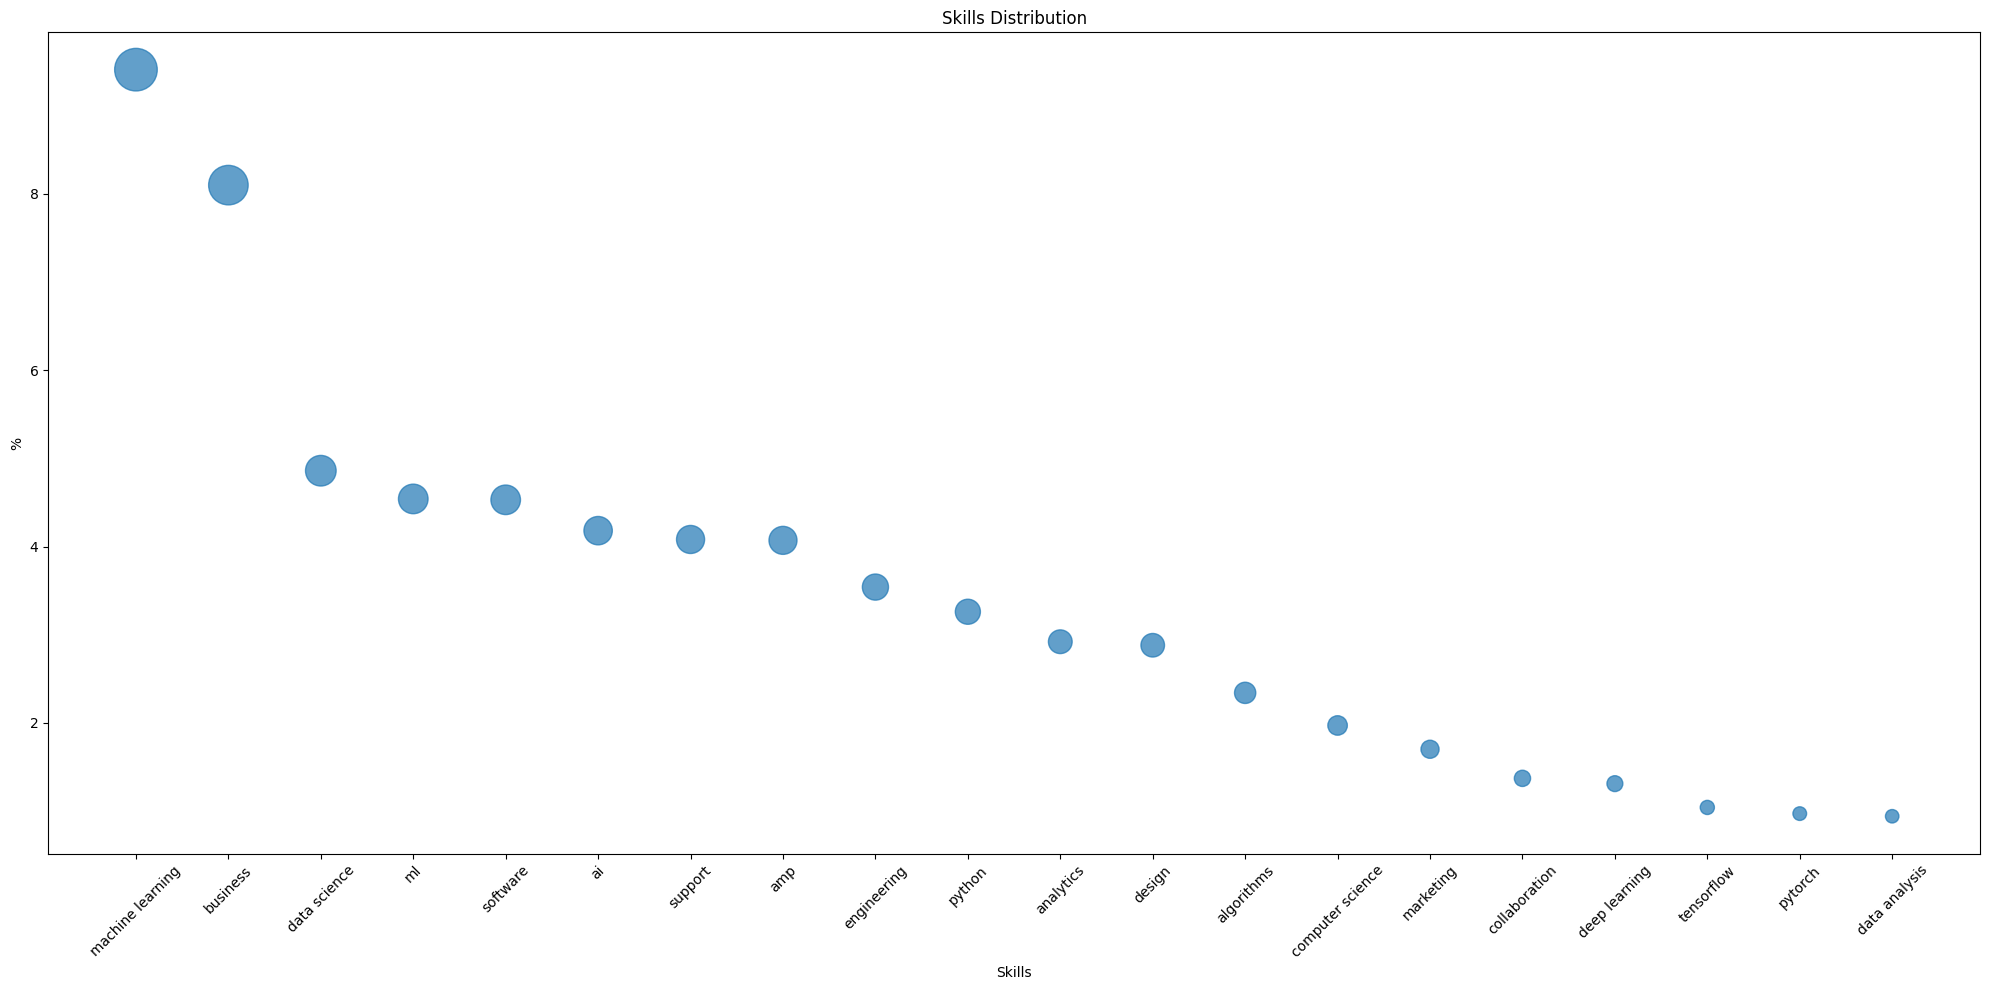

In [70]:
fig, ax = plt.subplots(figsize=(20, 10))


ax.scatter(view['skills'], view['percentual%'], s=view['percentual%']*100, alpha=0.7)

ax.set_xlabel('Skills')
ax.set_ylabel('%')
ax.set_title('Skills Distribution')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Example of detection of entities in description job

In [83]:
sent = nlp(data["description"].iloc[-2])
displacy.render(sent, style="ent", jupyter=True)

Example of dependency parsing in the first ten words in a description job

In [84]:
#Dependency Parsing
displacy.render(sent[0:10], style="dep", jupyter=True, options={"distance": 90})

Word cloud of most common words used in description in all filtered datasets with almost 3k examples

Text(0.5, 1.0, 'Most Used Words in DS and ML jobs')

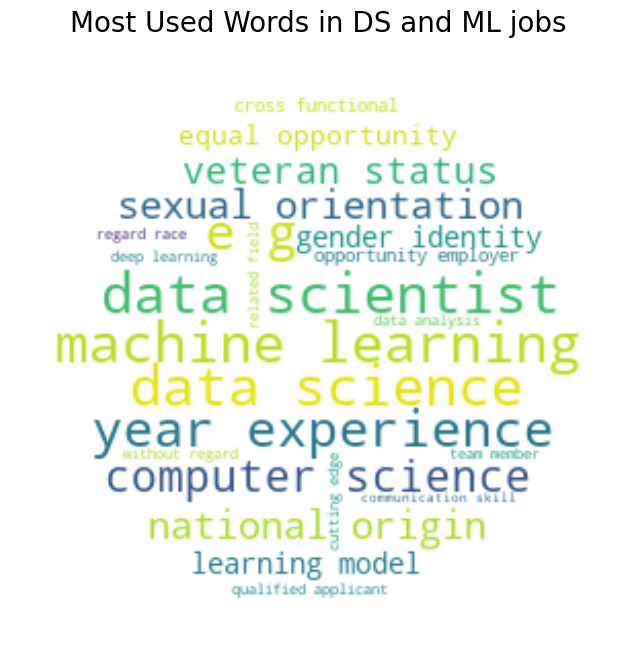

In [89]:
text = ""
#for i in data[data["title"] == Job_Category]["clean_description"].values:
for i in df_target["clean_description"].values:
    text += i + " "

plt.figure(figsize=(8, 8))

x, y = np.ogrid[:300, :300]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wc = WordCloud(
    width=800,
    height=800,
    background_color="white",
    min_font_size=6,
    repeat=True,
    mask=mask,
)
wc.generate(text)

plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.title(f"Most Used Words in DS and ML jobs", fontsize=20)

### Check the Match Score with one job and your skills

In [102]:
input_job = data.iloc[-2]['clean_description']

In [103]:
sent = nlp(data["description"].iloc[-2])
displacy.render(sent, style="ent", jupyter=True)

In [118]:
req_skills = ['data science', 'engineering', 'python', 'gcp']
resume_skills = unique_skills(get_skill(input_job))
score = 0
for x in req_skills:
    if x in resume_skills:
        score += 1
req_skills_len = len(req_skills)
match = round(score / req_skills_len * 100, 1)

print(f"The current job requirement is {match}% matched to your skills")

The current job requirement is 75.0% matched to your skills


### Topic Modeling - LDA

LDA, or the Latent Dirichlet Allocation, is arguably the most famous topic modeling algorithm.  
We create a simple topic model with five topics automatically extracted from all descriptions and skills, trying to form groups in which words can be related.

In [119]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [120]:
documents = df_target['clean_description'].tolist()

# vectorizer
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(documents)

# LDA
num_topics = 5  # Número de tópicos desejados
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(X)

# most relevant
feature_names = vectorizer.get_feature_names_out()
top_words = 10  # Número de palavras principais por tópico
for topic_idx, topic in enumerate(lda_model.components_):
    top_words_indices = topic.argsort()[:-top_words - 1:-1]
    top_words_list = [feature_names[i] for i in top_words_indices]
    print(f"Top words for Topic #{topic_idx + 1}: {', '.join(top_words_list)}")

Top words for Topic #1: data, research, experience, work, team, health, clinical, development, support, including
Top words for Topic #2: research, project, experience, client, work, team, health, data, policy, analysis
Top words for Topic #3: data, product, team, experience, work, company, client, science, role, development
Top words for Topic #4: experience, learning, work, team, machine, software, ml, product, model, data
Top words for Topic #5: data, experience, science, learning, business, machine, team, solution, model, work


In [121]:
nested_list = df_target['skills'].tolist()
unique_list = list(set(sum(nested_list, [])))
documents = unique_list

# vectorizer
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(documents)

# LDA
num_topics = 5  # Número de tópicos desejados
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(X)

# most relevant
feature_names = vectorizer.get_feature_names_out()
top_words = 10  # Número de palavras principais por tópico
for topic_idx, topic in enumerate(lda_model.components_):
    top_words_indices = topic.argsort()[:-top_words - 1:-1]
    top_words_list = [feature_names[i] for i in top_words_indices]
    print(f"Top words for Topic #{topic_idx + 1}: {', '.join(top_words_list)}")

Top words for Topic #1: model, network, analysis, language, code, computing, component, recognition, regression, environment
Top words for Topic #2: processing, programming, detection, feature, tracking, signal, customer, image, document, text
Top words for Topic #3: data, information, management, web, design, analytics, aws, algorithm, natural, language
Top words for Topic #4: learning, machine, azure, interface, support, time, cloud, user, virtual, decision
Top words for Topic #5: data, engineering, management, computer, knowledge, analysis, science, business, extraction, model


## Extract years of experience required in description

Using regex have better results than NER

In [72]:
# Define regular expression pattern to match the number of years
pattern = r'(\d+)\+?\s*(years|year|yrs|yr)'
matches = data['clean_description'].apply(lambda x: re.findall(pattern, x, re.IGNORECASE))

In [73]:
matches

0                                                  []
1                                                  []
2                   [(3, year), (3, year), (3, year)]
3                                                  []
4                                         [(2, year)]
                            ...                      
2775                                     [(10, year)]
2776                                               []
2777                                               []
2778    [(30, year), (5, year), (4, year), (1, year)]
2779                                     [(10, year)]
Name: clean_description, Length: 2780, dtype: object

In [74]:
# Extract the matched numbers and convert them to integers
matches.apply(lambda x: [int(match[0]) for match in x])

0                  []
1                  []
2           [3, 3, 3]
3                  []
4                 [2]
            ...      
2775             [10]
2776               []
2777               []
2778    [30, 5, 4, 1]
2779             [10]
Name: clean_description, Length: 2780, dtype: object

In [75]:
data['experience'] = matches.apply(lambda x: [int(match[0]) for match in x])
data.to_csv('ner_extracted.csv',index=False)

In [109]:
data.tail()

,title,location,company_name,position_name,experience_required,contract_type,function_name,company_sector,description,link,now_datetime,clean_description,skills,contract,education,constraints,experience,money
2775,Associate Director Clinical Research Scientist,"New York, NY",Actalent,Associate Director Clinical Research Scientist,Mid-Senior level,Full-time,"Research, Analyst, and Information Technology",Business Consulting and Services,"Role: Associate Director, Clinical Scientist (...",https://www.linkedin.com/jobs/view/3647912369,2023-06-28 03:13:21.161368,role associate director clinical scientist hem...,"[design, engineering]",[],[],[],[10],[multi billion dollar]
2776,Principal Scientist Clinical Pharmacology,"Wayne, PA",Actalent,Principal Scientist Clinical Pharmacology,Mid-Senior level,Full-time,"Research, Analyst, and Information Technology",Business Consulting and Services,100% REMOTE OPPORUNTIY- can be located anywher...,https://www.linkedin.com/jobs/view/3648986954,2023-06-29 03:14:23.702624,100 remote opporuntiy located anywhere within ...,"[simulation, amp, design, design, data analysi...",[],[],[],[],[]
2777,Principal Data Scientist,United States,Harnham,Principal Data Scientist,Mid-Senior level,Full-time,"Information Technology, Marketing, and Adverti...",IT Services and IT Consulting,Principal Data Scientist (Remote)United States...,https://www.linkedin.com/jobs/view/3650200805,2023-06-29 03:14:12.925404,principal data scientist remote united states2...,"[marketing, marketing, advertising, marketing,...",[],[],[],[],[]
2778,Machine Learning Engineer,United States,"EquinEdge, LLC.",Machine Learning Engineer,Mid-Senior level,Full-time,"Information Technology, Engineering, and Strat...",IT Services and IT Consulting and Software Dev...,Machine Learning EngineerJob Description:We ar...,https://www.linkedin.com/jobs/view/3641278894,2023-06-22 03:15:31.924397,machine learning engineerjob description looki...,"[machine learning, machine learning, machine l...",[],"[bachelor, master]",[],"[30, 5, 4, 1]",[]
2779,Principal Data Scientist,United States,Health Advocate,Principal Data Scientist,Mid-Senior level,Full-time,"Information Technology, Product Management, an...",Wellness and Fitness Services,The Principal Data Scientist will be at the fo...,https://www.linkedin.com/jobs/view/3649206683,2023-07-01 03:12:24.215699,principal data scientist forefront revolutioni...,"[ai, ai, ai, ai, ai, business, ai, ai, collabo...",[],[],[],[10],[]


In [78]:
df_to_save_in_cloud = data.copy()

In [80]:
df_to_save_in_cloud.tail()

,title,location,company_name,position_name,experience_required,contract_type,function_name,company_sector,description,link,now_datetime,clean_description,skills,contract,education,constraints,experience,money
2775,Associate Director Clinical Research Scientist,"New York, NY",Actalent,Associate Director Clinical Research Scientist,Mid-Senior level,Full-time,"Research, Analyst, and Information Technology",Business Consulting and Services,"Role: Associate Director, Clinical Scientist (...",https://www.linkedin.com/jobs/view/3647912369,2023-06-28 03:13:21.161368,role associate director clinical scientist hem...,"[design, engineering]",[],[],[],[10],[multi billion dollar]
2776,Principal Scientist Clinical Pharmacology,"Wayne, PA",Actalent,Principal Scientist Clinical Pharmacology,Mid-Senior level,Full-time,"Research, Analyst, and Information Technology",Business Consulting and Services,100% REMOTE OPPORUNTIY- can be located anywher...,https://www.linkedin.com/jobs/view/3648986954,2023-06-29 03:14:23.702624,100 remote opporuntiy located anywhere within ...,"[simulation, amp, design, design, data analysi...",[],[],[],[],[]
2777,Principal Data Scientist,United States,Harnham,Principal Data Scientist,Mid-Senior level,Full-time,"Information Technology, Marketing, and Adverti...",IT Services and IT Consulting,Principal Data Scientist (Remote)United States...,https://www.linkedin.com/jobs/view/3650200805,2023-06-29 03:14:12.925404,principal data scientist remote united states2...,"[marketing, marketing, advertising, marketing,...",[],[],[],[],[]
2778,Machine Learning Engineer,United States,"EquinEdge, LLC.",Machine Learning Engineer,Mid-Senior level,Full-time,"Information Technology, Engineering, and Strat...",IT Services and IT Consulting and Software Dev...,Machine Learning EngineerJob Description:We ar...,https://www.linkedin.com/jobs/view/3641278894,2023-06-22 03:15:31.924397,machine learning engineerjob description looki...,"[machine learning, machine learning, machine l...",[],"[bachelor, master]",[],"[30, 5, 4, 1]",[]
2779,Principal Data Scientist,United States,Health Advocate,Principal Data Scientist,Mid-Senior level,Full-time,"Information Technology, Product Management, an...",Wellness and Fitness Services,The Principal Data Scientist will be at the fo...,https://www.linkedin.com/jobs/view/3649206683,2023-07-01 03:12:24.215699,principal data scientist forefront revolutioni...,"[ai, ai, ai, ai, ai, business, ai, ai, collabo...",[],[],[],[10],[]


In [82]:
df_to_save_in_cloud["skills"] = df_to_save_in_cloud["skills"].apply(lambda x: ', '.join(x).strip('[]'))
df_to_save_in_cloud["contract"] = df_to_save_in_cloud["contract"].apply(lambda x: ', '.join(x).strip('[]'))
df_to_save_in_cloud["education"] = df_to_save_in_cloud["education"].apply(lambda x: ', '.join(x).strip('[]'))
df_to_save_in_cloud["constraints"] = df_to_save_in_cloud["constraints"].apply(lambda x: ', '.join(x).strip('[]'))
df_to_save_in_cloud["money"] = df_to_save_in_cloud["money"].apply(lambda x: ', '.join(x).strip('[]'))

In [84]:
df_to_save_in_cloud.tail()

,title,location,company_name,position_name,experience_required,contract_type,function_name,company_sector,description,link,now_datetime,clean_description,skills,contract,education,constraints,experience,money
2775,Associate Director Clinical Research Scientist,"New York, NY",Actalent,Associate Director Clinical Research Scientist,Mid-Senior level,Full-time,"Research, Analyst, and Information Technology",Business Consulting and Services,"Role: Associate Director, Clinical Scientist (...",https://www.linkedin.com/jobs/view/3647912369,2023-06-28 03:13:21.161368,role associate director clinical scientist hem...,"design, engineering",,,,[10],multi billion dollar
2776,Principal Scientist Clinical Pharmacology,"Wayne, PA",Actalent,Principal Scientist Clinical Pharmacology,Mid-Senior level,Full-time,"Research, Analyst, and Information Technology",Business Consulting and Services,100% REMOTE OPPORUNTIY- can be located anywher...,https://www.linkedin.com/jobs/view/3648986954,2023-06-29 03:14:23.702624,100 remote opporuntiy located anywhere within ...,"simulation, amp, design, design, data analysis...",,,,[],
2777,Principal Data Scientist,United States,Harnham,Principal Data Scientist,Mid-Senior level,Full-time,"Information Technology, Marketing, and Adverti...",IT Services and IT Consulting,Principal Data Scientist (Remote)United States...,https://www.linkedin.com/jobs/view/3650200805,2023-06-29 03:14:12.925404,principal data scientist remote united states2...,"marketing, marketing, advertising, marketing, ...",,,,[],
2778,Machine Learning Engineer,United States,"EquinEdge, LLC.",Machine Learning Engineer,Mid-Senior level,Full-time,"Information Technology, Engineering, and Strat...",IT Services and IT Consulting and Software Dev...,Machine Learning EngineerJob Description:We ar...,https://www.linkedin.com/jobs/view/3641278894,2023-06-22 03:15:31.924397,machine learning engineerjob description looki...,"machine learning, machine learning, machine le...",,"bachelor, master",,"[30, 5, 4, 1]",
2779,Principal Data Scientist,United States,Health Advocate,Principal Data Scientist,Mid-Senior level,Full-time,"Information Technology, Product Management, an...",Wellness and Fitness Services,The Principal Data Scientist will be at the fo...,https://www.linkedin.com/jobs/view/3649206683,2023-07-01 03:12:24.215699,principal data scientist forefront revolutioni...,"ai, ai, ai, ai, ai, business, ai, ai, collabor...",,,,[10],


In [95]:
df_to_save_in_cloud = df_to_save_in_cloud[['now_datetime','link','skills','contract','education','constraints','experience','money']]

In [96]:
df_to_save_in_cloud.tail()

,now_datetime,link,skills,contract,education,constraints,experience,money
2775,2023-06-28 03:13:21.161368,https://www.linkedin.com/jobs/view/3647912369,"design, engineering",,,,[10],multi billion dollar
2776,2023-06-29 03:14:23.702624,https://www.linkedin.com/jobs/view/3648986954,"simulation, amp, design, design, data analysis...",,,,[],
2777,2023-06-29 03:14:12.925404,https://www.linkedin.com/jobs/view/3650200805,"marketing, marketing, advertising, marketing, ...",,,,[],
2778,2023-06-22 03:15:31.924397,https://www.linkedin.com/jobs/view/3641278894,"machine learning, machine learning, machine le...",,"bachelor, master",,"[30, 5, 4, 1]",
2779,2023-07-01 03:12:24.215699,https://www.linkedin.com/jobs/view/3649206683,"ai, ai, ai, ai, ai, business, ai, ai, collabor...",,,,[10],


In [102]:
df_to_save_in_cloud_without_today = df_to_save_in_cloud.loc[df_to_save_in_cloud['now_datetime']< '2023-07-16'].sort_values("now_datetime",ascending=True)

In [103]:
df_to_save_in_cloud_without_today[['now_datetime','link','skills','contract','education','constraints','experience','money']].columns

Index(['now_datetime', 'link', 'skills', 'contract', 'education',
       'constraints', 'experience', 'money'],
      dtype='object')

## Save data processed in Big QUery

In [108]:
credentials = service_account.Credentials.from_service_account_file( 'teste-315517-6ebeb5337f4a.json', )    
pandas_gbq.context.credentials = credentials
project_id = 'teste-315517'
bigquery_client = bigquery.Client(credentials= credentials,project=project_id)

#save data in BigQuery table
table_id = 'teste-315517.teste.ner_extracted_from_linkedin'

#transform everything in string for avoid problemns in bigquery writing
df = df_to_save_in_cloud_without_today.astype(str)

job = bigquery_client.load_table_from_dataframe(
df, table_id)